<a href="https://colab.research.google.com/github/kserdem/NLP_Project_Sentiment_Analysis/blob/main/with_NLP__sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Kullanılan Kütüphanelerin İmport Edilmesi

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [30]:
!pip install nltk

In [31]:
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Veri Setinin Yüklenmesi

In [12]:
path="/content/drive/MyDrive/Projeler/NLP_Project/"
data=pd.read_csv(path+"train.txt",sep=";",header = None, names=["text","label"])



#Dataya İlk Bakış

In [13]:
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [17]:
a=data['label'].value_counts()

In [27]:
data['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
labels=["joy","sadness","anger","fear","love","surprise"]

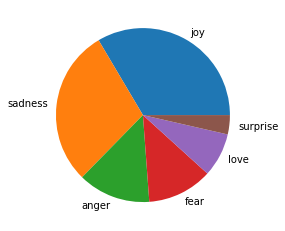

In [26]:
plt.pie(a,labels=labels)
plt.show() 

In [29]:
data['text']

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: text, Length: 16000, dtype: object

#Data Preprocess İşlemleri

#Metnin Küçük Harfe Çevrilmesi



*   Dataya ilk bakışta tüm veri seti küçük harf gibi görünüyor ancak tüm texti inceleyemediğimiz için yeniden bu işlemi yapıyoruz.




In [32]:
data['text']=data['text'].apply(lambda x: ' '.join(x.lower() for x in x.split() ))

In [33]:
data['label']=data['label'].apply(lambda x: ' '.join(x.lower() for x in x.split() ))

In [34]:
data.head(7)

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise


#Noktalama İşaetlerinin Kaldırılması

In [35]:
data['label']=data['label'].str.replace("[^\w\s]","")

In [36]:
data['text']=data['text'].str.replace("[^\w\s]","")

#Metinde Bulunan Sayıların Silinmesi

In [38]:
data['text']=data['text'].str.replace("\d","")

#StopWordslerin Silinmesi

In [ ]:
#text ingilizce olduğu için ingilizce stopwordsleri kullanacağız.
sw= stopwords.words("english")
sw

In [40]:
data['text']=data['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in sw))

In [41]:
data.head()

,text,label
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


#Metinde Az Geçen Kelimelerin Tespiti ve Silinmesi

In [43]:
sil=pd.Series(" ".join(data['text']).split()).value_counts()

In [44]:
sil

feel             11183
feeling           5112
like              2908
im                2430
really             942
                 ...  
chronicles           1
shies                1
illicit              1
intimated            1
contamination        1
Length: 15064, dtype: int64

In [107]:
sil=pd.Series(" ".join(data['text']).split()).value_counts()[-7810:]

In [108]:
sil

tent             1
creators         1
happend          1
spreadsheet      1
overdone         1
                ..
chronicles       1
shies            1
illicit          1
intimated        1
contamination    1
Length: 7810, dtype: int64

In [109]:
data['text']=data['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in sil))

#Lemmatization İşlemi

In [110]:
from textblob import Word
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [111]:
data['text']=data['text'].apply(lambda x: " ".join([Word(i).lemmatize() for i in x.split()]))

#Veri Setini Bölme

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
  data['text'], data['label'], test_size=0.30, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(11200,)
(4800,)
(11200,)


# Özellik Çıkarım Yötemleri

# **1) COUNT VECTORS**




In [114]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [115]:
x_train_count = vectorizer.transform(X_train)
x_test_count = vectorizer.transform(X_test)

In [119]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# **2) TF-IDF**

 **2.1) TF-IDF / WORDLEVEL**

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [126]:
x_train_tfidf_wordlevel = tf_idf_word_vectorizer.transform(X_train)
x_test_tfidf_wordlevel = tf_idf_word_vectorizer.transform(X_test)

**2.2) TF-IDF NGRAM LEVEL**

In [128]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [129]:
x_train_tfidf_ngram = tf_idf_ngram_vectorizer.transform(X_train)
x_test_tfidf_ngram = tf_idf_ngram_vectorizer.transform(X_test)

# Ön İşleme Adımları Yapılmış Dataya Makina Öğrenmesi Uygulanması

#NAİVE BAYES

In [136]:
nb_model = MultinomialNB().fit(x_train_count,y_train)
accuracy = cross_val_score(nb_model, 
                                     x_test_count, 
                                     y_test, 
                                     cv = 10).mean()

print("Count Vectors Doğrulanmış Accuracy:", accuracy)



Count Vectors Doğrulanmış Accuracy: 0.705


In [140]:
nb_model = MultinomialNB().fit(x_train_tfidf_wordlevel ,y_train)
accuracy = cross_val_score(nb_model, 
                                     x_test_tfidf_wordlevel, 
                                     y_test, 
                                     cv = 10).mean()

print("Word-Level Doğrulanmış Accuracy:", accuracy)


Word-Level Doğrulanmış Accuracy: 0.620625


In [139]:
nb_model = MultinomialNB().fit(x_train_tfidf_wordlevel ,y_train)
accuracy = cross_val_score(nb_model, 
                                           x_test_tfidf_ngram, 
                                           y_test, 
                                           cv = 10).mean()

print("N-GRAM Doğrulanmış Accuracy:", accuracy)

N-GRAM Doğrulanmış Accuracy: 0.5349999999999999


#LOJİSTİK REGRESYON

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

In [133]:
loj = LogisticRegression()
lojistik_model = loj.fit(x_train_count, y_train)
accuracy = cross_val_score(lojistik_model, 
                                           x_test_count, 
                                           y_test, 
                                           cv = 10).mean()

print("Count Vectors Doğrulanmış Accuracy:", accuracy)


Count Vectors Doğrulanmış Accuracy: 0.8533333333333333


In [134]:
loj = LogisticRegression()
lojistik_model = loj.fit(x_train_tfidf_wordlevel,y_train)
accuracy = cross_val_score(lojistik_model, 
                                           x_test_tfidf_wordlevel, 
                                           y_test, 
                                           cv = 10).mean()

print("Word-Level Doğrulanmış Accuracy:", accuracy)

Word-Level Doğrulanmış Accuracy: 0.7560416666666666


In [135]:

loj =LogisticRegression()
lojistik_model = loj.fit(x_train_tfidf_ngram,y_train)
accuracy = cross_val_score(lojistik_model, 
                                           x_test_tfidf_ngram, 
                                           y_test, 
                                           cv = 10).mean()

print("N-GRAM Doğrulanmış Accuracy:", accuracy)

N-GRAM Doğrulanmış Accuracy: 0.5885416666666667


#RANDOM FOREST

In [143]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
rf_model = RandomForestClassifier().fit(x_train_count,y_train)
accuracy = cross_val_score(rf_model, 
                                     x_test_count, 
                                     y_test, 
                                     cv = 10).mean()

print("Count Vectors Doğrulanmış Accuracy:", accuracy)



Count Vectors Doğrulanmış Accuracy: 0.8697916666666666


In [146]:
rf_model =RandomForestClassifier().fit(x_train_tfidf_wordlevel ,y_train)
accuracy = cross_val_score(rf_model, 
                                     x_test_tfidf_wordlevel, 
                                     y_test, 
                                     cv = 10).mean()

print("Word-Level Doğrulanmış Accuracy:", accuracy)


Word-Level Doğrulanmış Accuracy: 0.8491666666666667


In [147]:
rf_model = RandomForestClassifier().fit(x_train_tfidf_wordlevel ,y_train)
accuracy = cross_val_score(rf_model, 
                                           x_test_tfidf_ngram, 
                                           y_test, 
                                           cv = 10).mean()

print("N-GRAM Doğrulanmış Accuracy:", accuracy)

N-GRAM Doğrulanmış Accuracy: 0.6304166666666667


#Kurulan En İyi Model ile Yeni Yorumların Duygu Tahmini



*   En iyi model olarak Count Vectors yöntemiyle kurulan Random Forest modeli seçildi.




In [154]:
yorum= pd.Series(["I can't believe my eyes, are you kidding","I waited a long time for you but you didn't come. I cried all day","Mark tore her off the strip for being late",
                 "I was gobsmacked to learn that his brother is a spy."])

In [155]:
vector= CountVectorizer()
vector.fit(X_train)
yorum=vector.transform(yorum)

In [156]:
rf_model.predict(yorum)

array(['anger', 'joy', 'anger', 'anger'], dtype=object)